程式碼:
https://www.finlab.tw/%E7%94%A8%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92%E5%B9%AB%E4%BD%A0%E8%A7%A3%E6%9E%90k%E7%B7%9A%E5%9C%96%EF%BC%81/

# Load Data

In [1]:
from finlab.data import Data

data = Data()

sid = "2330"
amount = 3000
open_ = data.get("開盤價",amount)[sid]
low = data.get("開盤價",amount)[sid]
high = data.get("最高價",amount)[sid]
volume = data.get("成交股數",amount)[sid]
close = data.get("最低價",amount)[sid]

In [2]:
open_

date
2009-03-13     49.0
2009-03-16     50.0
2009-03-17     50.0
2009-03-18     50.2
2009-03-19     50.5
              ...  
2021-05-07    594.0
2021-05-10    596.0
2021-05-11    579.0
2021-05-12    567.0
2021-05-13    547.0
Name: 2330, Length: 3000, dtype: float64

In [3]:
import pandas as pd

foxconndf = pd.DataFrame({"open": open_, "low":low[:2000], "high": high[:2000], "volume":volume[:2000], "close": close[:2000]})
foxconndf.dropna(how='any',inplace=True)

In [4]:
foxconndf.head()

,open,low,high,volume,close
date,,,,,
2009-03-13,49.0,49.0,50.0,114489599.0,48.80
2009-03-16,50.0,50.0,50.1,74164352.0,49.85
2009-03-17,50.0,50.0,50.2,59583711.0,49.65
2009-03-18,50.2,50.2,50.5,80525987.0,49.75
2009-03-19,50.5,50.5,50.6,51242298.0,49.10


# 最小最大零一正規化

In [5]:
from sklearn import preprocessing

def normalize(df):
    newdf= df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    
    newdf['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    newdf['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    newdf['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    newdf['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    newdf['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    
    return newdf

foxconndf_norm= normalize(foxconndf)

In [6]:
foxconndf_norm.head()

,open,low,high,volume,close
date,,,,,
2009-03-13,0.004093,0.004093,0.002065,0.571678,0.007597
2009-03-16,0.010914,0.010914,0.002753,0.365587,0.014848
2009-03-17,0.010914,0.010914,0.003441,0.291069,0.013467
2009-03-18,0.012278,0.012278,0.005506,0.398099,0.014157
2009-03-19,0.014325,0.014325,0.006194,0.248438,0.009669


# 資料編輯

In [7]:
import numpy as np

def data_helper(df, time_frame):
    
    # 資料維度: 開盤價、收盤價、最高價、最低價、成交量, 5維
    number_features = len(df.columns)

    # 將dataframe 轉成 numpy array
    datavalue = df.values

    result = []
    # 若想要觀察的 time_frame 為20天, 需要多加一天做為驗證答案 -> 取21天(利用前20天預測地21天的收盤價)
    for index in range( len(datavalue) - (time_frame+1) ): # 從 datavalue 的第0個跑到倒數第 time_frame+1 個
        result.append(datavalue[index: index + (time_frame+1) ]) # 逐筆取出 time_frame+1 個K棒數值做為一筆 instance
    
    result = np.array(result)
    number_train = round(0.9 * result.shape[0]) # 取 result 的前90% instance做為訓練資料
    
    x_train = result[:int(number_train), :-1] # 訓練資料中, 只取每一個 time_frame 中除了最後一筆的所有資料做為feature
    y_train = result[:int(number_train), -1][:,-1] # 訓練資料中, 取每一個 time_frame 中最後一筆資料的最後一個數值(收盤價)做為答案
    
    # 測試資料
    x_test = result[int(number_train):, :-1]
    y_test = result[int(number_train):, -1][:,-1]
    
    # 將資料組成變好看一點
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], number_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], number_features))  

    return [x_train, y_train, x_test, y_test]

# 以20天為一區間進行股價預測
X_train, y_train, X_test, y_test = data_helper(foxconndf_norm, 20)

# Keras 模型建立

In [16]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import keras

def build_model(input_length, input_dim):
    d = 0.1
    model = Sequential()

    model.add(LSTM(256, input_shape=(input_length, input_dim), return_sequences=True))
    model.add(Dropout(d))

    model.add(LSTM(256, input_shape=(input_length, input_dim), return_sequences=False))
    model.add(Dropout(d))

    model.add(Dense(16,kernel_initializer="uniform",activation='relu'))
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

    return model

# 20天、5維
model = build_model( 20, 5 )

# LSTM 模型訓練

In [17]:
# 一個batch有128個instance，總共跑50個迭代
model.fit( X_train, y_train, batch_size=20, epochs=30, validation_split=0.1, verbose=1)

Epoch 1/30
81/81 [==============================] - 30s 248ms/step - loss: 0.0381 - accuracy: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 2/30
81/81 [==============================] - 18s 228ms/step - loss: 9.1305e-04 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 3/30
81/81 [==============================] - 16s 203ms/step - loss: 6.9009e-04 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 4/30
81/81 [==============================] - 19s 239ms/step - loss: 8.8075e-04 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 5/30
81/81 [==============================] - 22s 268ms/step - loss: 5.0071e-04 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 6/30
81/81 [==============================] - 24s 299ms/step - loss: 6.1029e-04 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 7/30
81/81 [==============================] - 19s 238ms/step - loss:

# LSTM 模型預測股價及還原數值

In [18]:
def denormalize(df, norm_value):
    original_value = df['close'].values.reshape(-1,1)
    norm_value = norm_value.reshape(-1,1)
    
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit_transform(original_value)
    denorm_value = min_max_scaler.inverse_transform(norm_value)
    
    return denorm_value

# 用訓練好的 LSTM 模型對測試資料集進行預測
pred = model.predict(X_test)

# 將預測值與正確答案還原回原來的區間值
denorm_pred = denormalize(foxconndf, pred)
denorm_ytest = denormalize(foxconndf, y_test)

# LSTM 預測股價結果
藍線是正確答案、紅線是預測股價

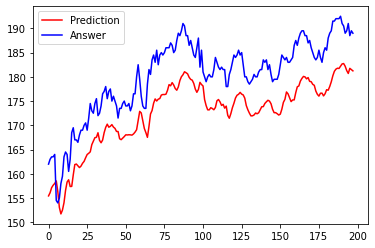

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.plot(denorm_pred,color='red', label='Prediction')
plt.plot(denorm_ytest,color='blue', label='Answer')
plt.legend(loc='best')
plt.show()

# 調整

試著來調整一些設定：  

時間框架長度的調整  
Keras 模型裡全連結層的 activation 與 optimizaer 的調整  
Keras 模型用不同的神經網路（種類、順序、數量）來組合  
batch_size 的調整、epochs 的調整  
…  